In [1]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import FNO
from neuralop import Trainer
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
from utils import get_dataloaders, TensorDataset
import numpy as np
from timeit import default_timer
import torch.nn.functional as F
import torch.nn as nn
from losses import EnergyScore
from models import FNO_reparam

device = 'cpu'

In [2]:
# Subsampling rate
sampling_rate = 2
ntrain = 1500
ntest = 150
batch_size = 32

t1 = 5
t2 = 9
data = np.load("data/ks_1d_data.npy").astype(np.float32)

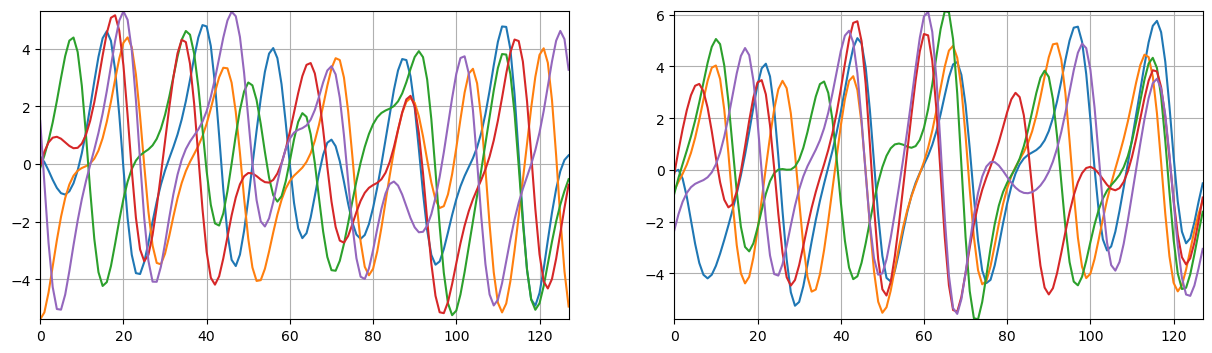

In [3]:
# Example plot
n_samples = np.random.randint(0,ntrain,5)

fig, axs = plt.subplots(1, 2, figsize = (15,4))
index = 0
for i in n_samples:
    axs[0].plot(data[i, t1])
    axs[1].plot(data[i, t2])


axs[0].grid(True)
axs[0].margins(0)
axs[1].grid(True)
axs[1].margins(0)

In [4]:
grid_range = 1

x_data = torch.tensor(data[:,t1])
y_data = torch.tensor(data[:,t2])
x_data = (x_data - x_data.mean()) / x_data.std()
y_data = (y_data - y_data.mean()) / y_data.std()
size_x = x_data.shape[1]
size_x_train = int(size_x/sampling_rate)

# Add channel dimension
x_data = x_data[:, None, :]
y_data = y_data[:, None, :]

x_train, y_train = x_data[:ntrain,:,::sampling_rate], y_data[:ntrain,:,::sampling_rate]
x_test, y_test = x_data[-ntest:], y_data[-ntest:]

# Add grid
gridx_train = torch.tensor(np.linspace(0, grid_range, size_x_train), dtype=torch.float)
gridx_train = gridx_train.reshape(1, 1, size_x_train)
gridx_test = torch.tensor(np.linspace(0, grid_range, size_x), dtype=torch.float)
gridx_test = gridx_test.reshape(1, 1, size_x)


x_train = torch.cat((x_train, gridx_train.repeat([ntrain, 1, 1])), dim=1)
x_test = torch.cat((x_test, gridx_test.repeat([ntest, 1, 1])), dim=1)

train_loader = torch.utils.data.DataLoader(TensorDataset(x_train, y_train),
                                        batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(TensorDataset(x_test, y_test),
                                        batch_size=batch_size, shuffle=False)
test_data = [x_test, y_test]

# Losses and parameters

In [5]:
l2loss = LpLoss(d=1, p=2, L = 50.0)
energy_score = EnergyScore(d = 1, p = 2, type = "lp", L = 50.0)

# Training parameters
epochs = 15
learning_rate = 0.002
dropout_rate = 0.1

# MC dropout

In [154]:
def generate_mc_samples(model, x, shape, n_samples=100):
    samples = torch.zeros(*shape, n_samples)
    for i in range(n_samples):
        with torch.no_grad():
            samples[...,i] = model(x).detach()
    return samples

In [155]:
model = FNO(n_modes=(16,), hidden_channels=32, projection_channels=64,
             in_channels = 2, use_mlp=True, mlp_dropout=dropout_rate)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()



Our model has 93537 parameters.


In [156]:
optimizer = torch.optim.Adam(model.parameters(),
                                lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [157]:
train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for sample in train_loader:
        x = sample["x"].to(device)
        y = sample["y"].to(device)

        optimizer.zero_grad()
        out = model(x)
        
        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2 = l2loss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward() # l2 relative loss

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for sample in test_loader:
            x = sample["x"].to(device)
            y= sample["y"].to(device)

            out = model(x)
            test_l2 += l2loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest
    
    train_loss[ep] = train_l2
    test_loss[ep] = test_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-MSE-{:0.4f}, Train-L2-{:0.4f}, Test-L2-{:0.4f}'
          .format(ep, t2-t1, train_mse, train_l2, test_l2))

Epoch-0, Time-1.9059, Train-MSE-0.9965, Train-L2-1.0009, Test-L2-1.0678
Epoch-1, Time-1.9923, Train-MSE-0.9893, Train-L2-0.9965, Test-L2-1.0635
Epoch-2, Time-1.6369, Train-MSE-0.9813, Train-L2-0.9920, Test-L2-1.0610
Epoch-3, Time-1.7224, Train-MSE-0.9716, Train-L2-0.9866, Test-L2-1.0562
Epoch-4, Time-1.8094, Train-MSE-0.9556, Train-L2-0.9781, Test-L2-1.0504
Epoch-5, Time-2.3401, Train-MSE-0.9418, Train-L2-0.9710, Test-L2-1.0511
Epoch-6, Time-2.3781, Train-MSE-0.9267, Train-L2-0.9631, Test-L2-1.0505
Epoch-7, Time-1.5279, Train-MSE-0.9119, Train-L2-0.9543, Test-L2-1.0411
Epoch-8, Time-1.4689, Train-MSE-0.8883, Train-L2-0.9413, Test-L2-1.0429
Epoch-9, Time-1.9135, Train-MSE-0.8722, Train-L2-0.9315, Test-L2-1.0331
Epoch-10, Time-1.7977, Train-MSE-0.8475, Train-L2-0.9174, Test-L2-1.0393
Epoch-11, Time-1.9379, Train-MSE-0.8280, Train-L2-0.9059, Test-L2-1.0302
Epoch-12, Time-1.8088, Train-MSE-0.8067, Train-L2-0.8928, Test-L2-1.0336
Epoch-13, Time-1.7656, Train-MSE-0.7809, Train-L2-0.8781, Tes

In [158]:
# %%
model.train()
""" Prediction """
pred = []
with torch.no_grad():    
    index = 0
    for sample in test_loader:
        x = sample["x"].to(device)
        y = sample["y"].to(device)
        out = generate_mc_samples(model, x, y.shape, n_samples=500)
        pred.append( out )


pred = torch.cat((pred))
mse_dropout = F.mse_loss(pred.mean(axis = -1).view(-1, size_x), y_test.view(-1, size_x)).item()
es_dropout = energy_score(pred, y_test).item()

print('MSE:', mse_dropout)
print('ES:', es_dropout)

MSE: 0.933302640914917
ES: 6.228389739990234


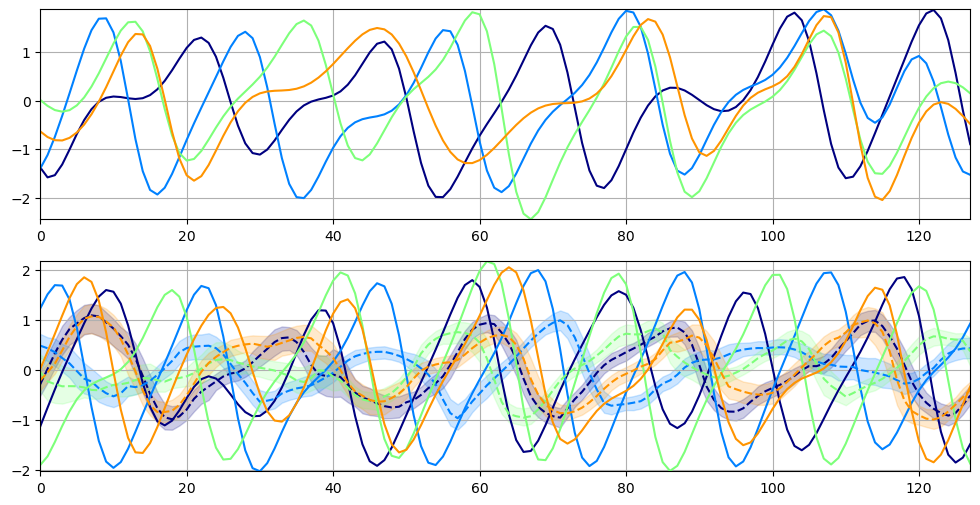

In [159]:
x_test, y_test = test_data
# %%


colormap = plt.cm.jet
colors = [colormap(i) for i in np.linspace(0, 1, 5)]

""" Plotting """ 
fig, axs = plt.subplots(2, 1, figsize = (12, 6))
index = 0
for i in range(y_test.shape[0]):
    if i % 40 == 1:
        axs[1].plot(y_test[i, 0].cpu().numpy(), color=colors[index], label='Actual')
        axs[1].plot(pred[i,0].mean(axis = -1).cpu().numpy(), '--', color=colors[index], label='Prediction')
        axs[0].plot(x_test[i,0].cpu().numpy(), color=colors[index], label='Actual')
        # Plot confidence bands
        axs[1].fill_between(np.arange(0, size_x), pred[i,0].quantile(0.025, axis = -1).cpu().numpy(),
                            pred[i,0].quantile(0.975, axis = -1).cpu().numpy() , color=colors[index], alpha=0.2)
        index += 1

axs[0].grid(True)
axs[0].margins(0)
axs[1].grid(True)
axs[1].margins(0)

# PFNO

In [14]:
sample_model = FNO_reparam(n_modes=(16,), hidden_channels=32, projection_channels=64, in_channels=2, n_samples = 5,
                           use_mlp=True, mlp_dropout=0)
# Model and optimizer
optimizer = torch.optim.Adam(sample_model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
# Loss function
energy_score = EnergyScore(d = 1, p = 2, type = "lp", L = 50.0)

In [15]:
train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)

for ep in range(epochs):
    sample_model.train()
    t1 = default_timer()
    train_l2 = 0
    for sample in train_loader:
        x = sample["x"].to(device)
        y = sample["y"].to(device)

        optimizer.zero_grad()
        out = sample_model(x)
        
        l2 = energy_score(out,y)
        l2.backward() # l2 relative loss

        optimizer.step()
        train_l2 += l2.item()

    scheduler.step()
    test_l2 = 0.0
    with torch.no_grad():
        for sample in test_loader:
            x = sample["x"].to(device)
            y= sample["y"].to(device)

            out = sample_model(x)
            test_l2 += energy_score(out,y).item()

    train_l2 /= ntrain
    test_l2 /= ntest
    
    train_loss[ep] = train_l2
    test_loss[ep] = test_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-L2-{:0.4f}, Test-L2-{:0.4f}'
          .format(ep, t2-t1, train_l2, test_l2))

Epoch-0, Time-1.7175, Train-L2-0.1560, Test-L2-0.1654
Epoch-1, Time-1.6303, Train-L2-0.1554, Test-L2-0.1660
Epoch-2, Time-1.8345, Train-L2-0.1553, Test-L2-0.1649
Epoch-3, Time-1.6837, Train-L2-0.1539, Test-L2-0.1640
Epoch-4, Time-1.0315, Train-L2-0.1527, Test-L2-0.1660
Epoch-5, Time-1.0930, Train-L2-0.1516, Test-L2-0.1633
Epoch-6, Time-1.3547, Train-L2-0.1498, Test-L2-0.1637
Epoch-7, Time-1.7256, Train-L2-0.1480, Test-L2-0.1632
Epoch-8, Time-2.1034, Train-L2-0.1463, Test-L2-0.1678
Epoch-9, Time-2.4097, Train-L2-0.1450, Test-L2-0.1627
Epoch-10, Time-1.7153, Train-L2-0.1427, Test-L2-0.1634
Epoch-11, Time-1.5254, Train-L2-0.1411, Test-L2-0.1618
Epoch-12, Time-1.8753, Train-L2-0.1387, Test-L2-0.1625
Epoch-13, Time-1.4787, Train-L2-0.1371, Test-L2-0.1627
Epoch-14, Time-1.5764, Train-L2-0.1333, Test-L2-0.1634


In [16]:
# %%
sample_model.eval()
""" Prediction """
pred = []
with torch.no_grad():    
    index = 0
    for sample in test_loader:
        x = sample["x"].to(device)
        y = sample["y"].to(device)
        out = sample_model(x, n_samples = 500)
        pred.append( out )


pred = torch.cat((pred))
mse = F.mse_loss(pred.mean(axis = -1).view(-1, size_x), y_test.view(-1, size_x)).item()
es = energy_score(pred, y_test).item()

print('MSE:', mse)
print('ES:', es)

MSE: 0.9648319482803345
ES: 4.88888692855835


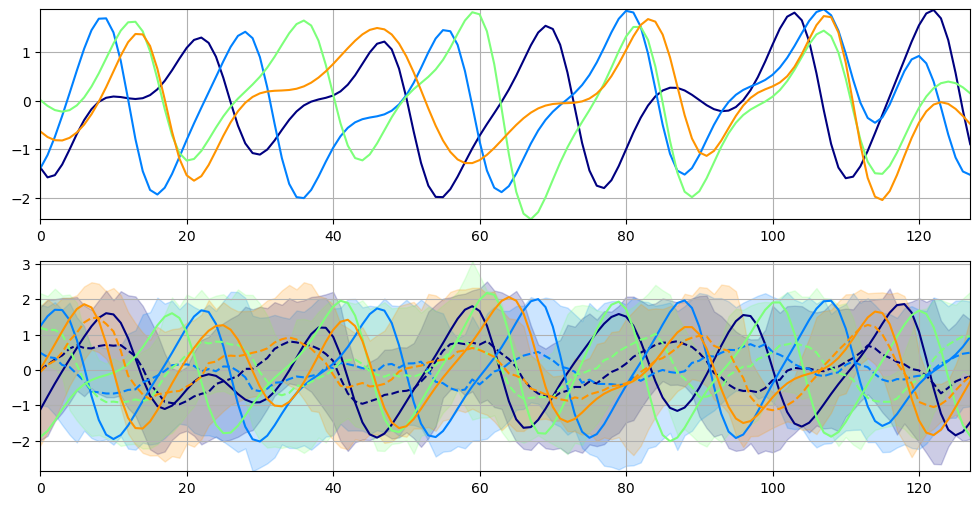

In [17]:
x_test, y_test = test_data
# %%


colormap = plt.cm.jet
colors = [colormap(i) for i in np.linspace(0, 1, 5)]

""" Plotting """ 
fig, axs = plt.subplots(2, 1, figsize = (12, 6))
index = 0
for i in range(y_test.shape[0]):
    if i % 40 == 1:
        axs[1].plot(y_test[i, 0].cpu().numpy(), color=colors[index], label='Actual')
        axs[1].plot(pred[i,0].mean(axis = -1).cpu().numpy(), '--', color=colors[index], label='Prediction')
        axs[0].plot(x_test[i,0].cpu().numpy(), color=colors[index], label='Actual')
        # Plot confidence bands
        axs[1].fill_between(np.arange(0, size_x), pred[i,0].quantile(0.025, axis = -1).cpu().numpy(),
                            pred[i,0].quantile(0.975, axis = -1).cpu().numpy() , color=colors[index], alpha=0.2)
        index += 1

axs[0].grid(True)
axs[0].margins(0)
axs[1].grid(True)
axs[1].margins(0)

In [164]:
# Comparison
print('MSE-Dropout:', mse_dropout)
print('ES-Dropout:', es_dropout)

print('MSE:', mse)
print('ES:', es)

MSE-Dropout: 0.933302640914917
ES-Dropout: 6.228389739990234
MSE: 1.0023823976516724
ES: 4.988565921783447
